In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import os
import zipfile
import urllib.request
from io import BytesIO
from scipy import stats

In [2]:

def load_uci_har_data(data_path):
    # Load activity labels
    activity_labels = pd.read_csv(os.path.join(data_path, 'activity_labels.txt'),
                                 delim_whitespace=True, header=None,
                                 names=['class_index', 'class_name'])

    # Load labels
    y_train = pd.read_csv(os.path.join(data_path, 'y_train.txt'), header=None)
    y_test = pd.read_csv(os.path.join(data_path, 'y_test.txt'), header=None)

    # Convert labels to numpy arrays
    y_train = y_train.values.flatten().astype('int32') - 1  # Make labels zero-indexed
    y_test = y_test.values.flatten().astype('int32') - 1  # Make labels zero-indexed

    # Load inertial signals data
    train_signals_paths = [
        os.path.join(data_path, 'body_acc_x_train.txt'),
        os.path.join(data_path, 'body_acc_y_train.txt'),
        os.path.join(data_path, 'body_acc_z_train.txt'),
        os.path.join(data_path, 'body_gyro_x_train.txt'),
        os.path.join(data_path, 'body_gyro_y_train.txt'),
        os.path.join(data_path, 'body_gyro_z_train.txt'),
        os.path.join(data_path, 'total_acc_x_train.txt'),
        os.path.join(data_path, 'total_acc_y_train.txt'),
        os.path.join(data_path, 'total_acc_z_train.txt')
    ]

    test_signals_paths = [
        os.path.join(data_path, 'body_acc_x_test.txt'),
        os.path.join(data_path, 'body_acc_y_test.txt'),
        os.path.join(data_path, 'body_acc_z_test.txt'),
        os.path.join(data_path, 'body_gyro_x_test.txt'),
        os.path.join(data_path, 'body_gyro_y_test.txt'),
        os.path.join(data_path, 'body_gyro_z_test.txt'),
        os.path.join(data_path, 'total_acc_x_test.txt'),
        os.path.join(data_path, 'total_acc_y_test.txt'),
        os.path.join(data_path, 'total_acc_z_test.txt')
    ]

    # Load and stack training data
    x_train_signals = []
    for path in train_signals_paths:
        signal = pd.read_csv(path, delim_whitespace=True, header=None).values
        x_train_signals.append(signal)

    # Load and stack test data
    x_test_signals = []
    for path in test_signals_paths:
        signal = pd.read_csv(path, delim_whitespace=True, header=None).values
        x_test_signals.append(signal)

    # Convert to numpy arrays with shape (n_samples, n_timestamps, n_features)
    # Each signal has shape (n_samples, n_timestamps)
    # We'll transpose to get shape (n_samples, n_timestamps, n_features)
    x_train = np.transpose(np.array(x_train_signals), (1, 2, 0)).astype('float32')
    x_test = np.transpose(np.array(x_test_signals), (1, 2, 0)).astype('float32')

    print(f"Loaded inertial signals data with shape: {x_train.shape} (train), {x_test.shape} (test)")

    # Normalize each feature independently
    n_samples_train, n_timestamps, n_features = x_train.shape
    n_samples_test = x_test.shape[0]

    # Reshape to normalize features independently
    x_train_reshaped = x_train.reshape((n_samples_train * n_timestamps, n_features))
    x_test_reshaped = x_test.reshape((n_samples_test * n_timestamps, n_features))

    # Normalize
    scaler = StandardScaler()
    x_train_reshaped = scaler.fit_transform(x_train_reshaped)
    x_test_reshaped = scaler.transform(x_test_reshaped)

    # Reshape back to original shape
    x_train = x_train_reshaped.reshape((n_samples_train, n_timestamps, n_features))
    x_test = x_test_reshaped.reshape((n_samples_test, n_timestamps, n_features))

    # One-hot encode labels
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=6)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=6)

    return x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, activity_labels

data_path = "/content/"
x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, activity_labels = load_uci_har_data(data_path)

print ("/content/activity_labels.txt")
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train_onehot.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test_onehot.shape}")
print("\nActivity labels:")
print(activity_labels)


<ipython-input-2-daf6ec1b3c13>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  activity_labels = pd.read_csv(os.path.join(data_path, 'activity_labels.txt'),
<ipython-input-2-daf6ec1b3c13>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(path, delim_whitespace=True, header=None).values
<ipython-input-2-daf6ec1b3c13>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(path, delim_whitespace=True, header=None).values
<ipython-input-2-daf6ec1b3c13>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal = pd.read_csv(path, delim_whitespace=True, header=None).valu

Loaded inertial signals data with shape: (7352, 128, 9) (train), (2947, 128, 9) (test)
/content/activity_labels.txt
Training data shape: (7352, 128, 9)
Training labels shape: (7352, 6)
Test data shape: (2947, 128, 9)
Test labels shape: (2947, 6)

Activity labels:
   class_index          class_name
0            1             WALKING
1            2    WALKING_UPSTAIRS
2            3  WALKING_DOWNSTAIRS
3            4             SITTING
4            5            STANDING
5            6              LAYING


In [3]:
def split_sequences(data, window_size=128, step=64):
    """
    Split the data into sequences with overlapping windows

    Args:
        data: Input data with shape (n_samples, n_features)
        window_size: Number of time steps in each sequence
        step: Step size between consecutive sequences

    Returns:
        Sequences with shape (n_sequences, window_size, n_features)
    """
    n_samples, n_features = data.shape
    sequences = []

    for i in range(0, n_samples - window_size + 1, step):
        sequence = data[i:i + window_size]
        sequences.append(sequence)

    return np.array(sequences)

# -----
# Since the inertial signals data is already in the format of (samples, timestamps, features),
# we don't need to use the split_sequences function for basic formatting, but we'll still use it
# if needed for resizing or overlap

# Check the current shape of the data
print(f"Original training data shape: {x_train.shape}")
print(f"Original test data shape: {x_test.shape}")

# The data already has 128 timestamps per sample, so we can use it directly
# If we need to adjust window size or create overlapping windows:
window_size = 128  # This is already the size in the dataset
step = 128  # Non-overlapping by default - set to smaller value for overlap

# Check if we need to reshape the data
if x_train.shape[1] != window_size or step != window_size:
    print("Reshaping data to adjust window size or create overlapping samples...")
    # Flatten the data to 2D and then recreate sequences
    x_train_flat = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])
    x_test_flat = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])

    # Create new sequences
    x_train_seq = split_sequences(x_train_flat, window_size=window_size, step=step)
    x_test_seq = split_sequences(x_test_flat, window_size=window_size, step=step)

    # Create corresponding labels for sequences
    # For each sequence, we'll use the mode of the labels
    orig_samples_per_window = x_train.shape[1] / window_size

    y_train_seq = []
    for i in range(0, len(x_train_flat) - window_size + 1, step):
        # Map back to original sample indices
        orig_sample_idx = int(i / x_train.shape[1])
        mode_label = y_train[orig_sample_idx]
        y_train_seq.append(mode_label)

    y_test_seq = []
    for i in range(0, len(x_test_flat) - window_size + 1, step):
        # Map back to original sample indices
        orig_sample_idx = int(i / x_test.shape[1])
        mode_label = y_test[orig_sample_idx]
        y_test_seq.append(mode_label)

    y_train_seq = np.array(y_train_seq)
    y_test_seq = np.array(y_test_seq)
else:
    # If no reshaping is needed, use the data directly
    x_train_seq = x_train
    x_test_seq = x_test
    y_train_seq = y_train
    y_test_seq = y_test

# One-hot encode labels
y_train_seq_onehot = tf.keras.utils.to_categorical(y_train_seq, num_classes=6)
y_test_seq_onehot = tf.keras.utils.to_categorical(y_test_seq, num_classes=6)

print(f"Final training data shape: {x_train_seq.shape}")
print(f"Final training labels shape: {y_train_seq_onehot.shape}")
print(f"Final test data shape: {x_test_seq.shape}")
print(f"Final test labels shape: {y_test_seq_onehot.shape}")


Original training data shape: (7352, 128, 9)
Original test data shape: (2947, 128, 9)
Final training data shape: (7352, 128, 9)
Final training labels shape: (7352, 6)
Final test data shape: (2947, 128, 9)
Final test labels shape: (2947, 6)


In [4]:
X_train_seq = x_train_seq.copy()
X_test_seq = x_test_seq.copy()

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers # Import optimizers here

# -------------------------
# ABFA 모듈 정의
# -------------------------
class ABFA(tf.keras.layers.Layer):
    def __init__(self, filters, activity_classes=6, dropout_rate=0.2, **kwargs):
        super(ABFA, self).__init__(**kwargs)
        self.filters = filters
        self.activity_classes = activity_classes
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.action_prototypes = self.add_weight(
            name='action_prototypes',
            shape=(self.activity_classes, input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.embedding_proj = layers.Dense(input_shape[-1])
        self.augment_proj = layers.Dense(input_shape[-1])
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(self.dropout_rate)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)
        super().build(input_shape)

    def call(self, inputs):
        x_proj = self.embedding_proj(inputs)
        proto_similarity = tf.einsum('btd,cd->btc', x_proj, self.action_prototypes)
        proto_attention = tf.nn.softmax(proto_similarity, axis=-1)
        enhanced = tf.einsum('btc,cd->btd', proto_attention, self.action_prototypes)
        augmented = self.augment_proj(enhanced)
        x = self.bn(inputs + augmented)
        x = self.dropout(x)
        return self.layer_norm(x)

# -------------------------
# MST Block 정의
# -------------------------
class MST_Block(layers.Layer):
    def __init__(self, filters, kernel_sizes=(3, 5, 7), **kwargs):
        super(MST_Block, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_sizes = kernel_sizes

        if len(kernel_sizes) == 3:
            self.filter_dims = [filters // 4, filters // 4, filters // 2]
        else:
            self.filter_dims = [filters // 2, filters // 2]

        self.conv_layers = []
        for i, k_size in enumerate(kernel_sizes):
            self.conv_layers.append(
                layers.DepthwiseConv1D(
                    kernel_size=k_size,
                    strides=1,
                    padding='same',
                    depth_multiplier=1
                )
            )
        self.proj_layers = [
            layers.Conv1D(self.filter_dims[i], kernel_size=1, padding='same') for i in range(len(kernel_sizes))
        ]
        self.output_proj = layers.Conv1D(filters, kernel_size=1)

    def call(self, inputs):
        outputs = []
        for conv, proj in zip(self.conv_layers, self.proj_layers):
            x = conv(inputs)
            x = proj(x)
            outputs.append(x)
        x = layers.Concatenate()(outputs)
        return self.output_proj(x)

# -------------------------
# 모델 정의
# -------------------------
def build_model3(input_shape, num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # Initial projection
    x = layers.Conv1D(64, kernel_size=1, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(128, kernel_size=1, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Multi-Scale CNN Path
    kernel_sizes = [3, 7, 11]
    multi_scale_outputs = []
    for k in kernel_sizes:
        branch = layers.Conv1D(
            filters=128 // len(kernel_sizes),
            kernel_size=k,
            padding='same',
            activation='relu'
        )(x)
        branch = layers.BatchNormalization()(branch)
        multi_scale_outputs.append(branch)

    x = layers.Concatenate()(multi_scale_outputs)
    x = layers.Conv1D(128, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ABFA block
    x = ABFA(filters=128, activity_classes=num_classes)(x)

    # MST block
    x = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(x)

    # Transformer Encoder block (1 layer)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)
    ffn_output = layers.Dense(128, activation='relu')(x)
    ffn_output = layers.Dense(128)(ffn_output)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization()(x)

    # GlobalAveragePooling + Classifier
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


model3 = build_model3(input_shape=(window_size, X_train_seq.shape[2]))
model3.summary()

# Compile the model
model3.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 128)  │      8,320 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 42)   │     16,170 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 42)   │     37,674 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 42)   │     59,178 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 128, 128)  │     16,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa (ABFA)         │ (None, 128, 128)  │     34,560 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block          │ (None, 128, 128)  │     35,328 │ abfa[0][0]        │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ mst__block[0][0]

 Total params: 400,572 (1.53 MB)

 Trainable params: 399,424 (1.52 MB)

 Non-trainable params: 1,148 (4.48 KB)

In [6]:
# import os
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers, callbacks
# from sklearn.model_selection import train_test_split # Import train_test_split


X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq_onehot, test_size=0.2, random_state=42
)

# early_stopping = callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )

# reduce_lr = callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=5,
#     min_lr=1e-5
# )

# history = model3.fit(
#     X_train_split,
#     y_train_split,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_val_split, y_val_split),
#     callbacks=[early_stopping, reduce_lr],
#     verbose=1
# )

In [7]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks


# # Assuming your activity labels are in a CSV file, load them
# # Replace 'activity_labels.csv' with the actual file path
# try:
#     activity_labels = pd.read_csv('activity_labels.csv')
# except FileNotFoundError:
#     # If the file doesn't exist, create a DataFrame manually
#     activity_labels = pd.DataFrame({
#         'class_name': ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
#         'label': [0, 1, 2, 3, 4, 5]  # Assuming labels are 0-indexed
#     })

# y_pred_probs = model3.predict(X_test_seq)  # Get predicted probabilities
# y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
# y_true = np.argmax(y_test_seq_onehot, axis=1)  # Get true labels from one-hot encoded data


# precision = precision_score(y_true, y_pred, average='weighted')
# recall = recall_score(y_true, y_pred, average='weighted')
# f1 = f1_score(y_true, y_pred, average='weighted')
# # Calculate specificity for each class
# def specificity_score(y_true, y_pred, num_classes=6):
#     specificities = []

#     for i in range(num_classes):
#         true_negative = np.sum((y_true != i) & (y_pred != i))
#         false_positive = np.sum((y_true != i) & (y_pred == i))

#         if true_negative  false_positive == 0:
#             specificities.append(1.0)
#         else:
#             specificities.append(true_negative / (true_negative + false_positive))

#     return specificities

# specificities = specificity_score(y_true, y_pred)
# avg_specificity = np.mean(specificities)

# test_loss, test_acc = model3.evaluate(X_test_seq, y_test_seq_onehot, verbose=0)

# print("\nEvaluation Metrics:")
# print(f"Accuracy: {test_acc:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print(f"Average Specificity: {avg_specificity:.4f}")

# print("\nClass-wise Specificities:")
# for i, spec in enumerate(specificities):
#     print(f"Class {i} ({activity_labels.iloc[i, 0]}): {spec:.4f}") # Assuming 'class_name' is in the first column (index 0)

# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#            xticklabels=activity_labels['class_name'].values,
#            yticklabels=activity_labels['class_name'].values)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - PatchFormer (UCI-HAR)')
# plt.tight_layout()
# plt.show()

In [9]:
'''

Input (batch_size, time_steps, channels)
    ↓
[Initial Projection]
    Conv1D(kernel=1, filters=64) → BatchNorm → ReLU
    ↓
    Conv1D(kernel=1, filters=128) → BatchNorm → ReLU
    ↓
[Multi-Scale CNN Path]
    ┌─ Conv1D(kernel=3,  filters=128/3≈42) → BatchNorm
    ├─ Conv1D(kernel=7,  filters=128/3≈42) → BatchNorm
    └─ Conv1D(kernel=11, filters=128/3≈42) → BatchNorm
        ↓
    Concatenate(branches) → Conv1D(kernel=1, filters=128) → BatchNorm → ReLU
    ↓
[ABFA Block]
    • 입력 차원: (time_steps, 128)
    • action_prototypes: (num_classes, 128)
    • 내부:
        – Dense→프로젝트 → proto 유사도 계산 → softmax attention
        – attention ⊗ prototypes → augment_proj → residual + BN → Dropout → LayerNorm
    ↓
[MST_Block]
    • DepthwiseConv1D(kernel=3) → Conv1D(filters=32)
    • DepthwiseConv1D(kernel=5) → Conv1D(filters=32)
    • DepthwiseConv1D(kernel=7) → Conv1D(filters=64)
        ↓
    Concatenate → Conv1D(kernel=1, filters=128)
    ↓
[Transformer Encoder Block]
    MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
      → Add(x) → LayerNormalization
    ↓
    Feed-Forward: Dense(128, ReLU) → Dense(128)
      → Add(x) → LayerNormalization
    ↓
GlobalAveragePooling1D
    ↓
Dense(128, ReLU) → Dropout(0.2) → Dense(64, ReLU)
    ↓
Dense(num_classes, Softmax)
초기 투영(Initial Projection): 1×1 컨볼루션으로 채널 차원 확장

다중 스케일 CNN(Multi-Scale CNN Path): 서로 다른 커널 크기로 병렬 특징 추출 후 통합

ABFA Block: 학습된 행동 프로토타입과의 attention 기반 특징 증강

MST_Block: 깊이별(depthwise) 컨볼루션으로 다중 스케일 시간 특징 캡처

Transformer Encoder: 자기-어텐션과 FFN으로 시퀀스 전역 관계 학습

분류기(Classifier): 전역 풀링 후 완전 연결 계층으로 최종 클래스 예측

'''

'\n\nInput (batch_size, time_steps, channels)\n    ↓\n[Initial Projection]\n    Conv1D(kernel=1, filters=64) → BatchNorm → ReLU\n    ↓\n    Conv1D(kernel=1, filters=128) → BatchNorm → ReLU\n    ↓\n[Multi-Scale CNN Path]\n    ┌─ Conv1D(kernel=3,  filters=128/3≈42) → BatchNorm\n    ├─ Conv1D(kernel=7,  filters=128/3≈42) → BatchNorm\n    └─ Conv1D(kernel=11, filters=128/3≈42) → BatchNorm\n        ↓\n    Concatenate(branches) → Conv1D(kernel=1, filters=128) → BatchNorm → ReLU\n    ↓\n[ABFA Block]\n    • 입력 차원: (time_steps, 128)\n    • action_prototypes: (num_classes, 128)\n    • 내부:\n        – Dense→프로젝트 → proto 유사도 계산 → softmax attention\n        – attention ⊗ prototypes → augment_proj → residual + BN → Dropout → LayerNorm\n    ↓\n[MST_Block]\n    • DepthwiseConv1D(kernel=3) → Conv1D(filters=32)\n    • DepthwiseConv1D(kernel=5) → Conv1D(filters=32)\n    • DepthwiseConv1D(kernel=7) → Conv1D(filters=64)\n        ↓\n    Concatenate → Conv1D(kernel=1, filters=128)\n    ↓\n[Transformer Encoder

---


Building and training model: IP _ MSCP _ CH


Model: "model126"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 128, 42)   │     16,170 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 128, 42)   │     37,674 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 128, 42)   │     59,178 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 128, 128)  │     16,256 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ re_lu_5[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]   

 Total params: 165,180 (645.23 KB)

 Trainable params: 164,288 (641.75 KB)

 Non-trainable params: 892 (3.48 KB)


Total params: 165,180
Trainable params: 164,288
Non-trainable params: 892
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.6025 - loss: 1.2490 - val_accuracy: 0.8960 - val_loss: 0.6756 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9193 - loss: 0.3524 - val_accuracy: 0.9551 - val_loss: 0.1800 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9410 - loss: 0.1867 - val_accuracy: 0.9545 - val_loss: 0.1174 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9460 - loss: 0.1489 - val_accuracy: 0.9599 - val_loss: 0.1037 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9470 - loss: 0.1331 - val_accuracy: 0.9551 - val_loss: 0.0990 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9482 - loss: 0.1322 - val_accuracy: 0.9606 - val_loss: 0.0946 - learnin

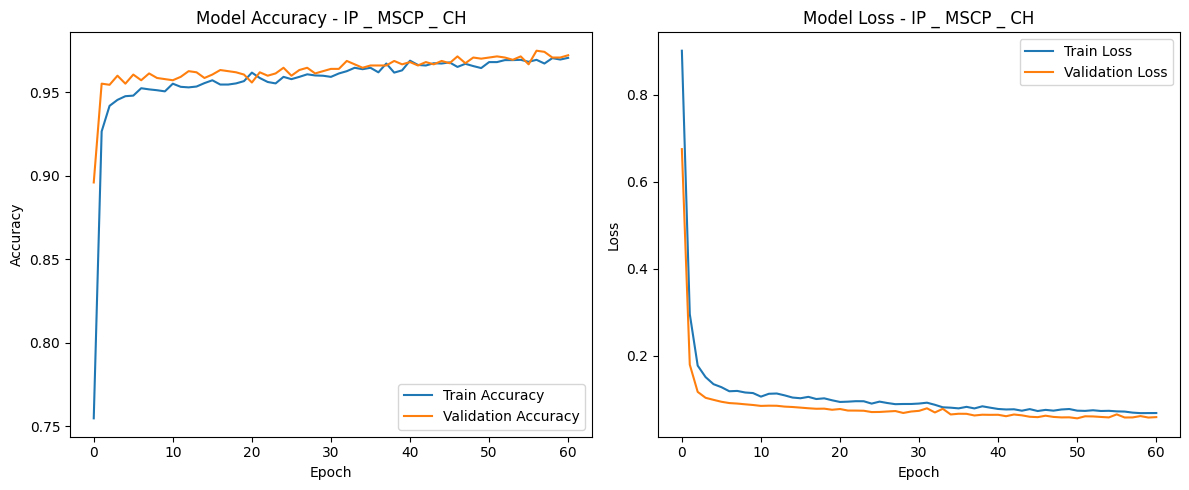

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


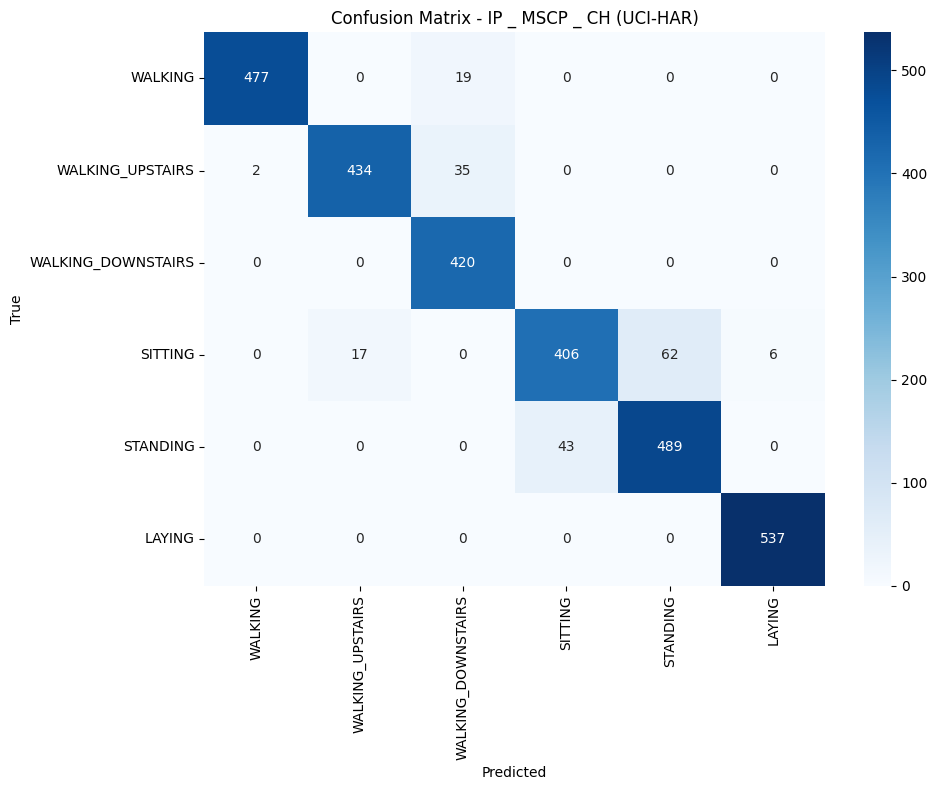


Evaluation Metrics for IP _ MSCP _ CH on UCI-HAR:
Accuracy: 0.9376
Precision: 0.9388
Recall: 0.9376
F1 Score: 0.9372

Per-Class Metrics:
WALKING: Accuracy = 0.9929, F1 = 0.9785
WALKING_UPSTAIRS: Accuracy = 0.9817, F1 = 0.9414
WALKING_DOWNSTAIRS: Accuracy = 0.9817, F1 = 0.9396
SITTING: Accuracy = 0.9566, F1 = 0.8638
STANDING: Accuracy = 0.9644, F1 = 0.9030
LAYING: Accuracy = 0.9980, F1 = 0.9944
Model saved as model126_UCI-HAR.h5

Building and training model: IP _ MSCP _ ABFA _ CH


Model: "model1236"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 128, 42)   │     16,170 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 128, 42)   │     37,674 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 128, 42)   │     59,178 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 128, 128)  │     16,256 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_1 (ABFA)       │ (None, 128, 128)  │     34,560 │ re_lu_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ abfa_1[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     16,512 │ global_average_p

 Total params: 199,740 (780.23 KB)

 Trainable params: 198,592 (775.75 KB)

 Non-trainable params: 1,148 (4.48 KB)


Total params: 199,740
Trainable params: 198,592
Non-trainable params: 1,148
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.6396 - loss: 1.0532 - val_accuracy: 0.8851 - val_loss: 0.3652 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9225 - loss: 0.2972 - val_accuracy: 0.9517 - val_loss: 0.1255 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9429 - loss: 0.1656 - val_accuracy: 0.9565 - val_loss: 0.0994 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9455 - loss: 0.1458 - val_accuracy: 0.9572 - val_loss: 0.0940 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9468 - loss: 0.1416 - val_accuracy: 0.9626 - val_loss: 0.0879 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9488 - loss: 0.1197 - val_accuracy: 0.9606 - val_loss: 0.0868 - learn

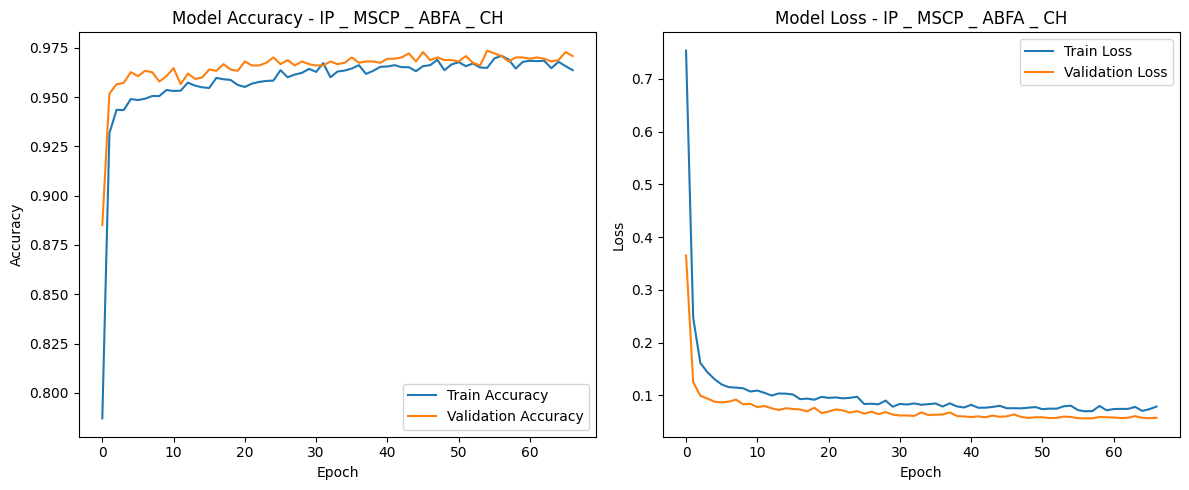

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


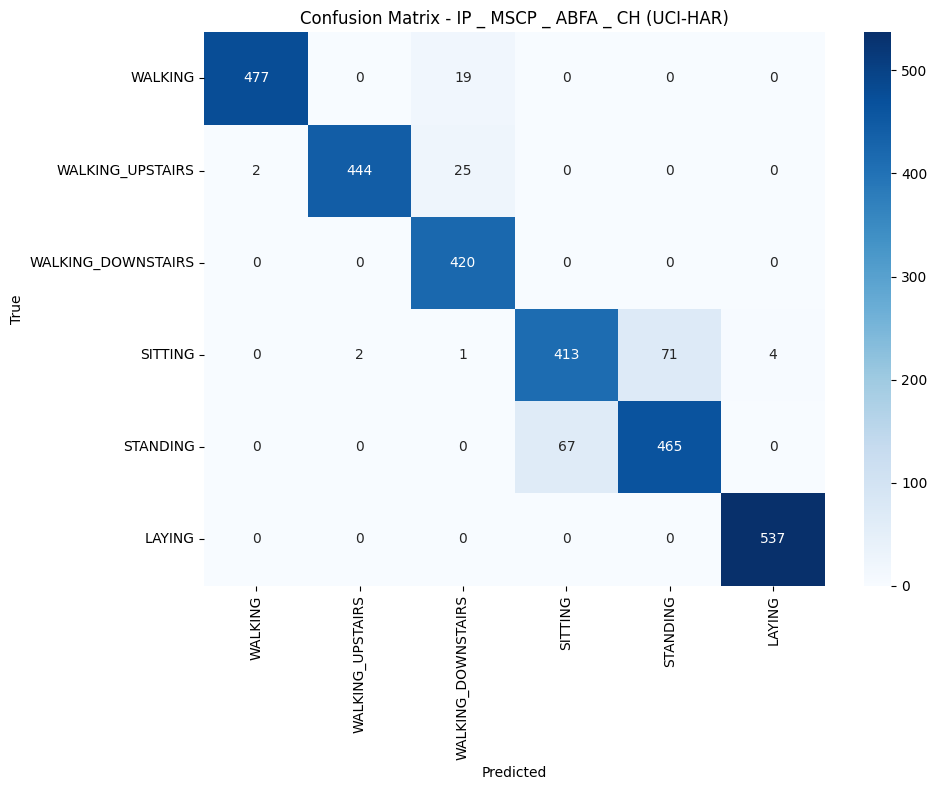


Evaluation Metrics for IP _ MSCP _ ABFA _ CH on UCI-HAR:
Accuracy: 0.9352
Precision: 0.9363
Recall: 0.9352
F1 Score: 0.9352

Per-Class Metrics:
WALKING: Accuracy = 0.9929, F1 = 0.9785
WALKING_UPSTAIRS: Accuracy = 0.9902, F1 = 0.9684
WALKING_DOWNSTAIRS: Accuracy = 0.9847, F1 = 0.9492
SITTING: Accuracy = 0.9508, F1 = 0.8507
STANDING: Accuracy = 0.9532, F1 = 0.8708
LAYING: Accuracy = 0.9986, F1 = 0.9963
Model saved as model1236_UCI-HAR.h5

Building and training model: IP _ MSCP _ MST _ CH


Model: "model1246"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 128, 42)   │     16,170 │ re_lu_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 128, 42)   │     37,674 │ re_lu_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 128, 42)   │     59,178 │ re_lu_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 128, 128)  │     16,256 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_1        │ (None, 128, 128)  │     35,328 │ re_lu_11[0][0]    │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ mst__block_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 200,508 (783.23 KB)

 Trainable params: 199,616 (779.75 KB)

 Non-trainable params: 892 (3.48 KB)


Total params: 200,508
Trainable params: 199,616
Non-trainable params: 892
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.5421 - loss: 1.4204 - val_accuracy: 0.9143 - val_loss: 0.6241 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9219 - loss: 0.3089 - val_accuracy: 0.9504 - val_loss: 0.1534 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9431 - loss: 0.1592 - val_accuracy: 0.9545 - val_loss: 0.1106 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9405 - loss: 0.1430 - val_accuracy: 0.9592 - val_loss: 0.1031 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9441 - loss: 0.1349 - val_accuracy: 0.9572 - val_loss: 0.0980 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9412 - loss: 0.1305 - val_accuracy: 0.9599 - val_loss: 0.0975 - le

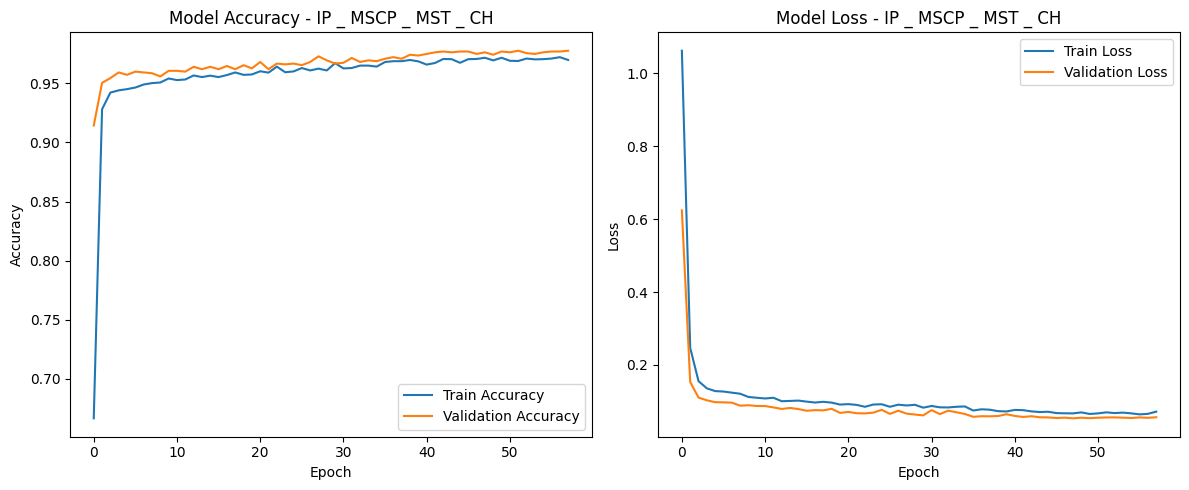

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


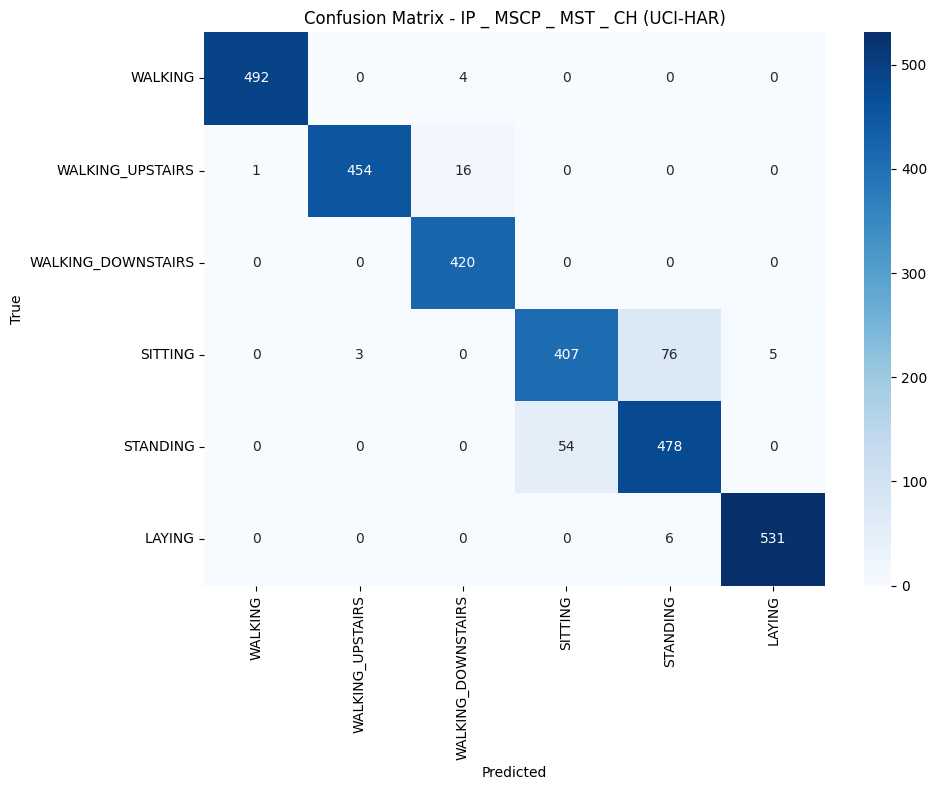


Evaluation Metrics for IP _ MSCP _ MST _ CH on UCI-HAR:
Accuracy: 0.9440
Precision: 0.9445
Recall: 0.9440
F1 Score: 0.9439

Per-Class Metrics:
WALKING: Accuracy = 0.9983, F1 = 0.9949
WALKING_UPSTAIRS: Accuracy = 0.9932, F1 = 0.9784
WALKING_DOWNSTAIRS: Accuracy = 0.9932, F1 = 0.9767
SITTING: Accuracy = 0.9532, F1 = 0.8550
STANDING: Accuracy = 0.9539, F1 = 0.8755
LAYING: Accuracy = 0.9963, F1 = 0.9897
Model saved as model1246_UCI-HAR.h5

Building and training model: IP _ MSCP _ TEB _ CH


Model: "model1256"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 128, 42)   │     16,170 │ re_lu_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 128, 42)   │     37,674 │ re_lu_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 128, 42)   │     59,178 │ re_lu_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_34[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_35[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 128, 128)  │     16,256 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ re_lu_14[0][0],   │
│ (MultiHeadAttentio… │                   │            │ re_lu_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128)  │          0 │ re_lu_14[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 330,684 (1.26 MB)

 Trainable params: 329,792 (1.26 MB)

 Non-trainable params: 892 (3.48 KB)


Total params: 330,684
Trainable params: 329,792
Non-trainable params: 892
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.6430 - loss: 0.9840 - val_accuracy: 0.9211 - val_loss: 0.2597 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9352 - loss: 0.1926 - val_accuracy: 0.9497 - val_loss: 0.1072 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9409 - loss: 0.1536 - val_accuracy: 0.9579 - val_loss: 0.1014 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9487 - loss: 0.1305 - val_accuracy: 0.9572 - val_loss: 0.0937 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9505 - loss: 0.1182 - val_accuracy: 0.9619 - val_loss: 0.0915 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9473 - loss: 0.1194 - val_accuracy: 0.9579 - val_loss: 0.0852 - lear

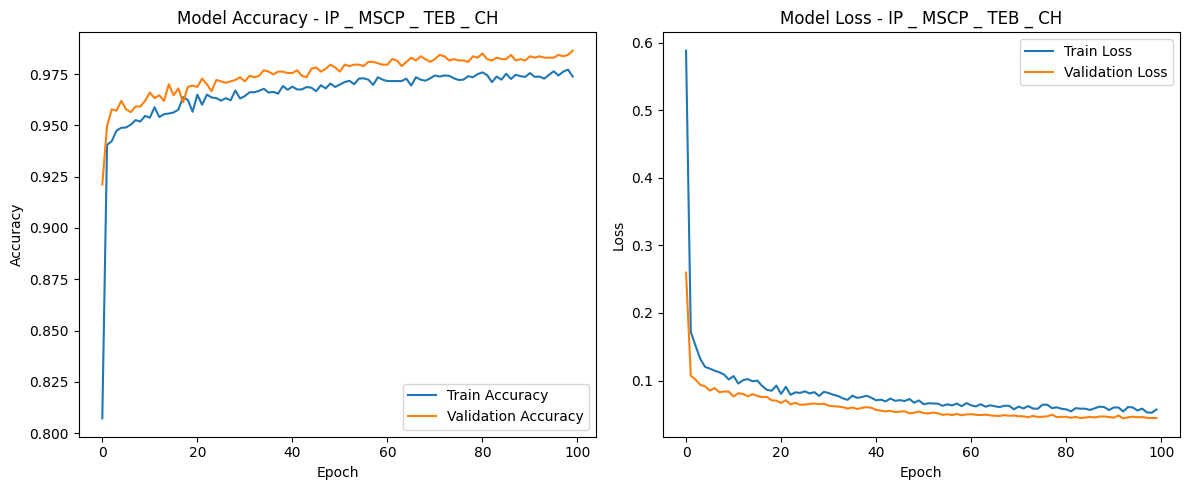

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


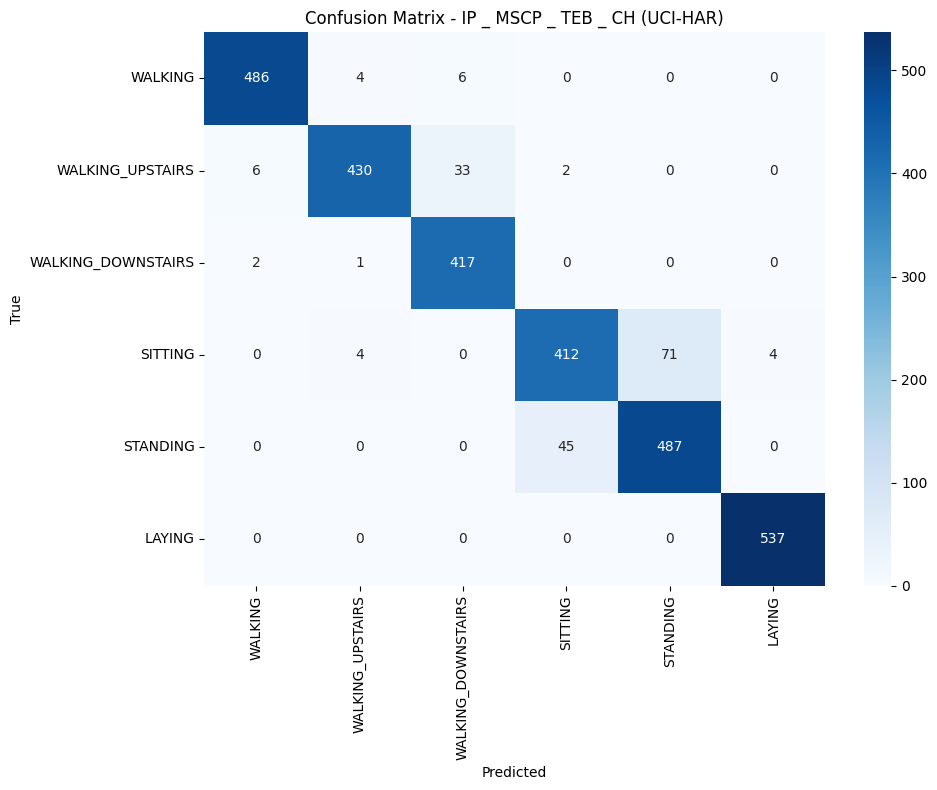


Evaluation Metrics for IP _ MSCP _ TEB _ CH on UCI-HAR:
Accuracy: 0.9396
Precision: 0.9404
Recall: 0.9396
F1 Score: 0.9393

Per-Class Metrics:
WALKING: Accuracy = 0.9939, F1 = 0.9818
WALKING_UPSTAIRS: Accuracy = 0.9830, F1 = 0.9451
WALKING_DOWNSTAIRS: Accuracy = 0.9857, F1 = 0.9521
SITTING: Accuracy = 0.9572, F1 = 0.8674
STANDING: Accuracy = 0.9606, F1 = 0.8936
LAYING: Accuracy = 0.9986, F1 = 0.9963
Model saved as model1256_UCI-HAR.h5

Building and training model: IP _ ABFA _ CH


Model: "model136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 128, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 128, 128)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ abfa_2 (ABFA)                   │ (None, 128, 128)       │        34,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,446 (271.27 KB)

 Trainable params: 68,806 (268.77 KB)

 Non-trainable params: 640 (2.50 KB)


Total params: 69,446
Trainable params: 68,806
Non-trainable params: 640
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.4204 - loss: 1.4244 - val_accuracy: 0.7559 - val_loss: 0.6806 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7660 - loss: 0.6987 - val_accuracy: 0.8736 - val_loss: 0.4134 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8502 - loss: 0.4662 - val_accuracy: 0.9123 - val_loss: 0.2617 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8863 - loss: 0.3374 - val_accuracy: 0.9266 - val_loss: 0.2043 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9094 - loss: 0.2659 - val_accuracy: 0.9443 - val_loss: 0.1620 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9200 - loss: 0.2236 - val_accuracy: 0.9422 - val_loss: 0.1462 - learning

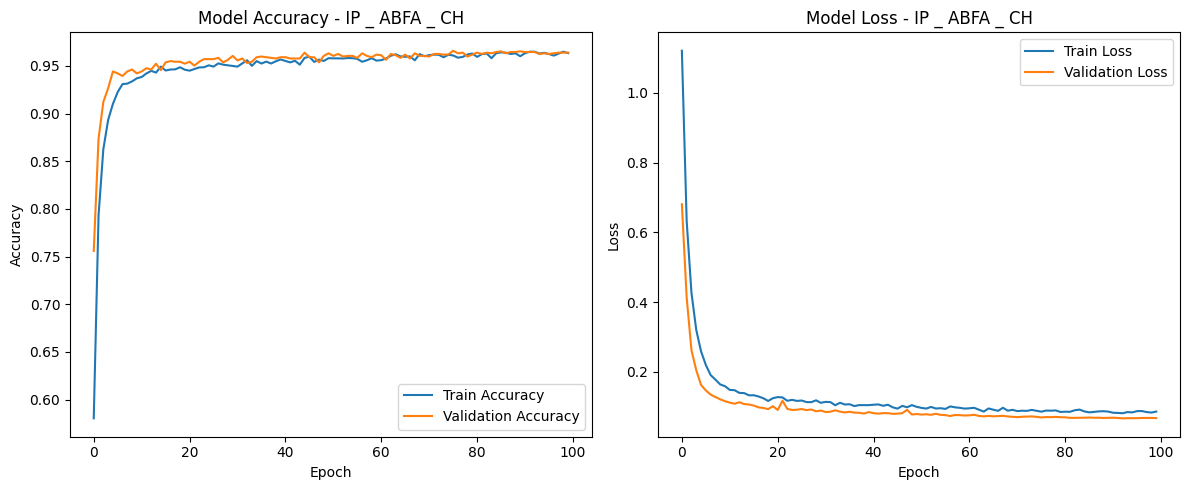

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


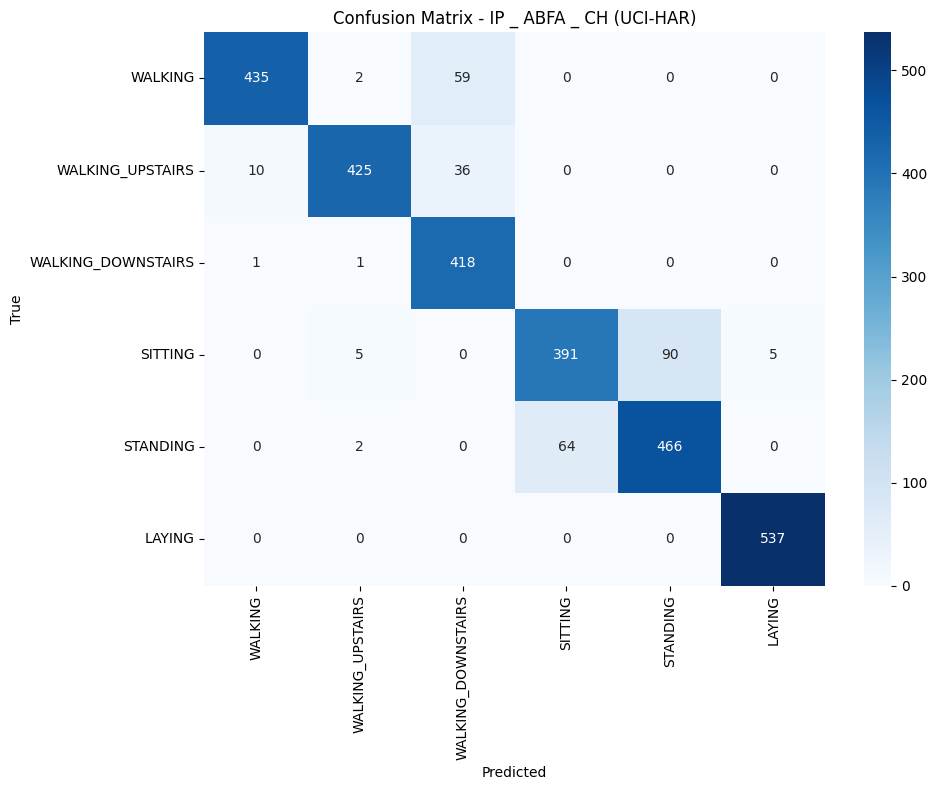


Evaluation Metrics for IP _ ABFA _ CH on UCI-HAR:
Accuracy: 0.9067
Precision: 0.9114
Recall: 0.9067
F1 Score: 0.9068

Per-Class Metrics:
WALKING: Accuracy = 0.9756, F1 = 0.9236
WALKING_UPSTAIRS: Accuracy = 0.9810, F1 = 0.9382
WALKING_DOWNSTAIRS: Accuracy = 0.9671, F1 = 0.8960
SITTING: Accuracy = 0.9444, F1 = 0.8266
STANDING: Accuracy = 0.9471, F1 = 0.8566
LAYING: Accuracy = 0.9983, F1 = 0.9954
Model saved as model136_UCI-HAR.h5

Building and training model: IP _ ABFA _ TEB _ CH


Model: "model1356"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_3 (ABFA)       │ (None, 128, 128)  │     34,560 │ re_lu_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ abfa_3[0][0],     │
│ (MultiHeadAttentio… │                   │            │ abfa_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 128, 128)  │          0 │ abfa_3[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 128, 128)  │     16,512 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 128, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 6)         │        390 │ dense_33[0][0]  

 Total params: 234,950 (917.77 KB)

 Trainable params: 234,310 (915.27 KB)

 Non-trainable params: 640 (2.50 KB)


Total params: 234,950
Trainable params: 234,310
Non-trainable params: 640
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.5192 - loss: 1.1650 - val_accuracy: 0.8593 - val_loss: 0.4752 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8425 - loss: 0.4784 - val_accuracy: 0.9375 - val_loss: 0.1812 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9123 - loss: 0.2516 - val_accuracy: 0.9477 - val_loss: 0.1319 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9286 - loss: 0.1883 - val_accuracy: 0.9483 - val_loss: 0.1195 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9377 - loss: 0.1539 - val_accuracy: 0.9524 - val_loss: 0.1074 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9450 - loss: 0.1342 - val_accuracy: 0.9538 - val_loss: 0.1069 - learni

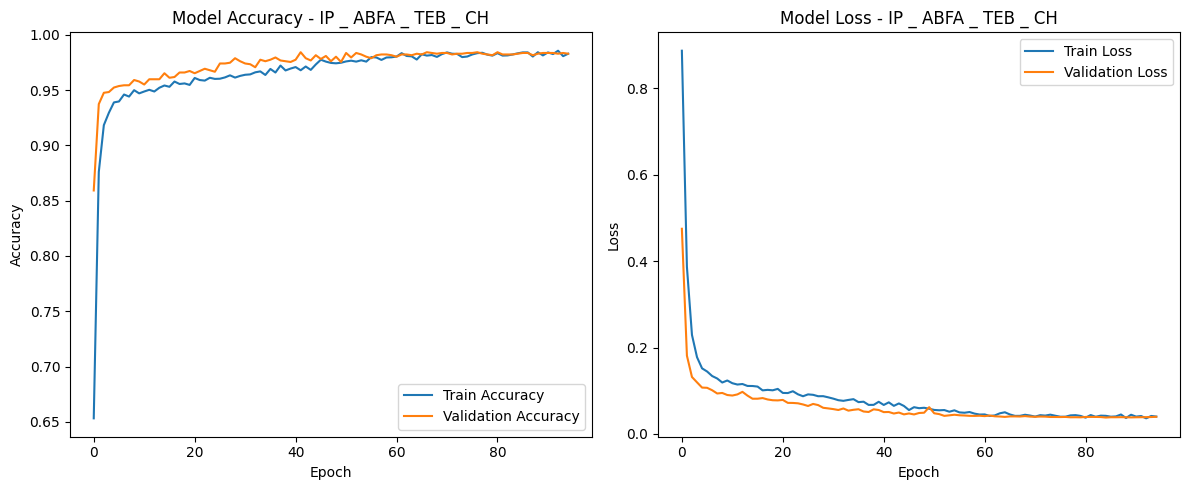

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


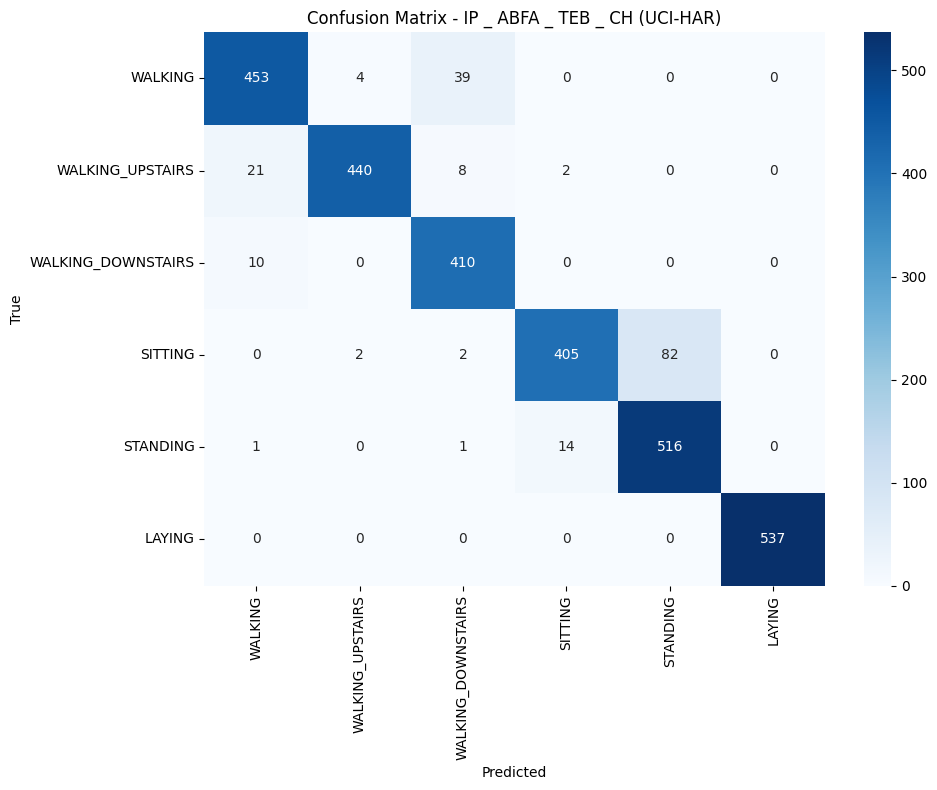


Evaluation Metrics for IP _ ABFA _ TEB _ CH on UCI-HAR:
Accuracy: 0.9369
Precision: 0.9402
Recall: 0.9369
F1 Score: 0.9367

Per-Class Metrics:
WALKING: Accuracy = 0.9746, F1 = 0.9235
WALKING_UPSTAIRS: Accuracy = 0.9874, F1 = 0.9597
WALKING_DOWNSTAIRS: Accuracy = 0.9796, F1 = 0.9318
SITTING: Accuracy = 0.9654, F1 = 0.8882
STANDING: Accuracy = 0.9667, F1 = 0.9133
LAYING: Accuracy = 1.0000, F1 = 1.0000
Model saved as model1356_UCI-HAR.h5

Building and training model: IP _ ABFA _ MST _ CH


Model: "model1346"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 128, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 128, 128)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ abfa_4 (ABFA)                   │ (None, 128, 128)       │        34,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mst__block_2 (MST_Block)        │ (None, 128, 128)       │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,774 (409.27 KB)

 Trainable params: 104,134 (406.77 KB)

 Non-trainable params: 640 (2.50 KB)


Total params: 104,774
Trainable params: 104,134
Non-trainable params: 640
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4642 - loss: 1.4650 - val_accuracy: 0.7247 - val_loss: 0.6147 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7331 - loss: 0.6473 - val_accuracy: 0.8280 - val_loss: 0.4233 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8196 - loss: 0.4553 - val_accuracy: 0.9130 - val_loss: 0.2354 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9030 - loss: 0.2760 - val_accuracy: 0.9150 - val_loss: 0.1951 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9210 - loss: 0.2159 - val_accuracy: 0.9354 - val_loss: 0.1493 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9251 - loss: 0.1890 - val_accuracy: 0.9524 - val_loss: 0.1370 - learni

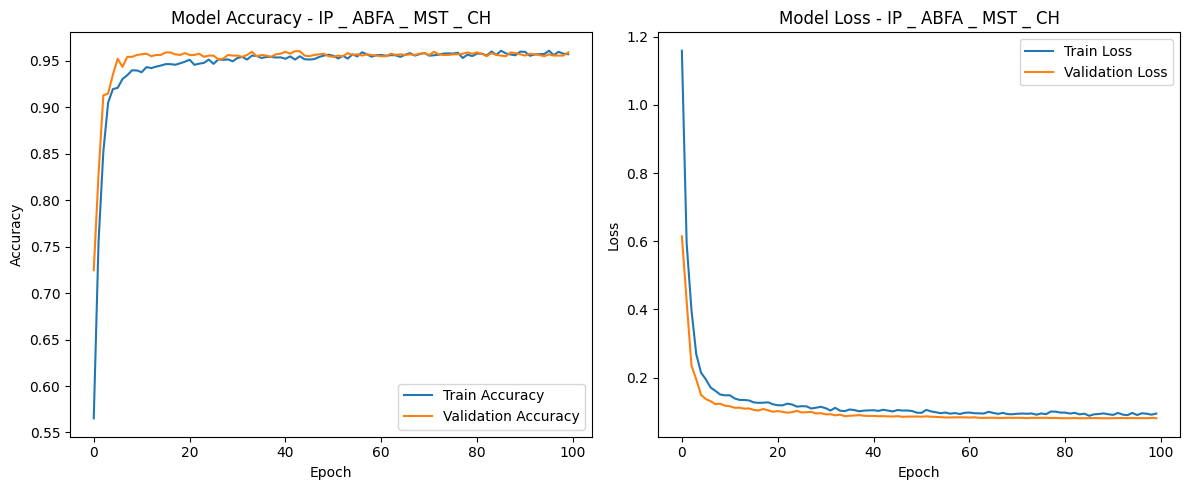

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


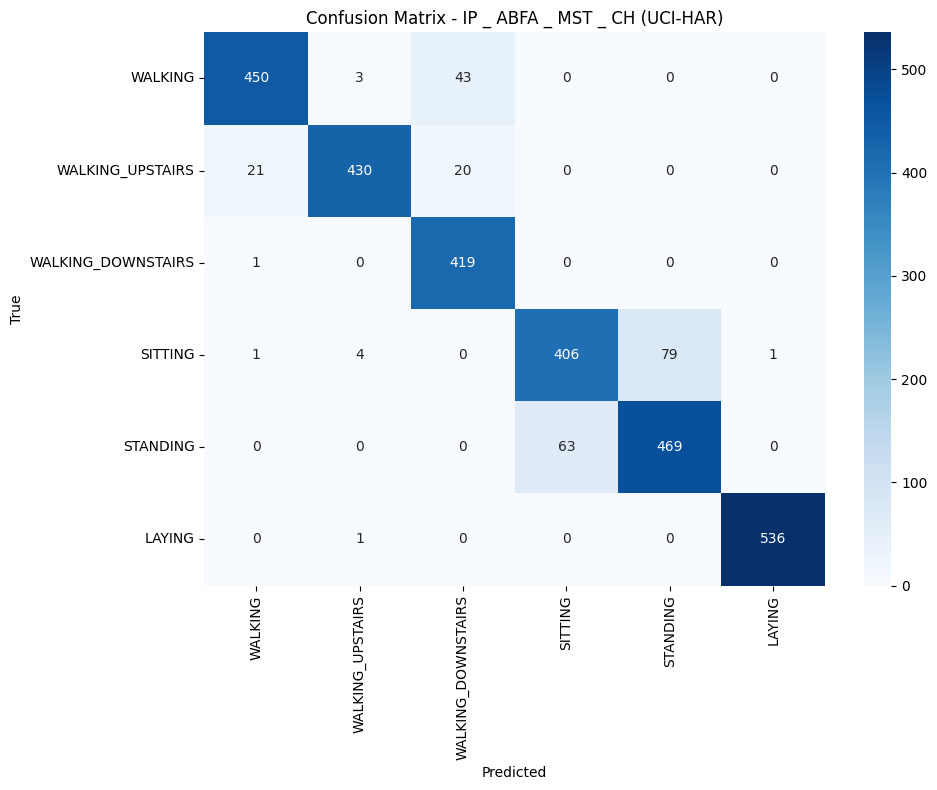


Evaluation Metrics for IP _ ABFA _ MST _ CH on UCI-HAR:
Accuracy: 0.9196
Precision: 0.9215
Recall: 0.9196
F1 Score: 0.9195

Per-Class Metrics:
WALKING: Accuracy = 0.9766, F1 = 0.9288
WALKING_UPSTAIRS: Accuracy = 0.9834, F1 = 0.9461
WALKING_DOWNSTAIRS: Accuracy = 0.9783, F1 = 0.9290
SITTING: Accuracy = 0.9498, F1 = 0.8458
STANDING: Accuracy = 0.9518, F1 = 0.8685
LAYING: Accuracy = 0.9993, F1 = 0.9981
Model saved as model1346_UCI-HAR.h5

Building and training model: IP _ MSCP _ ABFA _ TEB _ CH


Model: "model12356"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_48[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_49[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 128, 42)   │     16,170 │ re_lu_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 128, 42)   │     37,674 │ re_lu_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 128, 42)   │     59,178 │ re_lu_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_50[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_51[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_52[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 128, 128)  │     16,256 │ concatenate_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_53[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_5 (ABFA)       │ (None, 128, 128)  │     34,560 │ re_lu_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ abfa_5[0][0],     │
│ (MultiHeadAttentio… │                   │            │ abfa_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 128, 128)  │          0 │ abfa_5[0][0],   

 Total params: 365,244 (1.39 MB)

 Trainable params: 364,096 (1.39 MB)

 Non-trainable params: 1,148 (4.48 KB)


Total params: 365,244
Trainable params: 364,096
Non-trainable params: 1,148
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - accuracy: 0.5975 - loss: 1.0333 - val_accuracy: 0.9137 - val_loss: 0.2466 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9222 - loss: 0.2526 - val_accuracy: 0.9504 - val_loss: 0.1125 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9383 - loss: 0.1591 - val_accuracy: 0.9592 - val_loss: 0.0982 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9423 - loss: 0.1453 - val_accuracy: 0.9619 - val_loss: 0.0967 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9471 - loss: 0.1274 - val_accuracy: 0.9599 - val_loss: 0.0938 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9468 - loss: 0.1210 - val_accuracy: 0.9606 - val_loss: 0.0920 - 

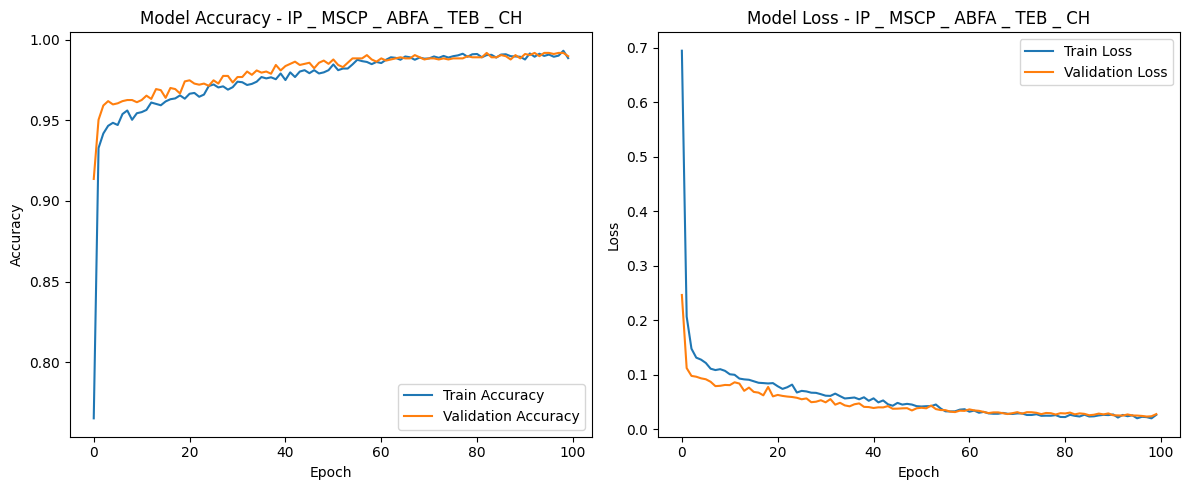

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


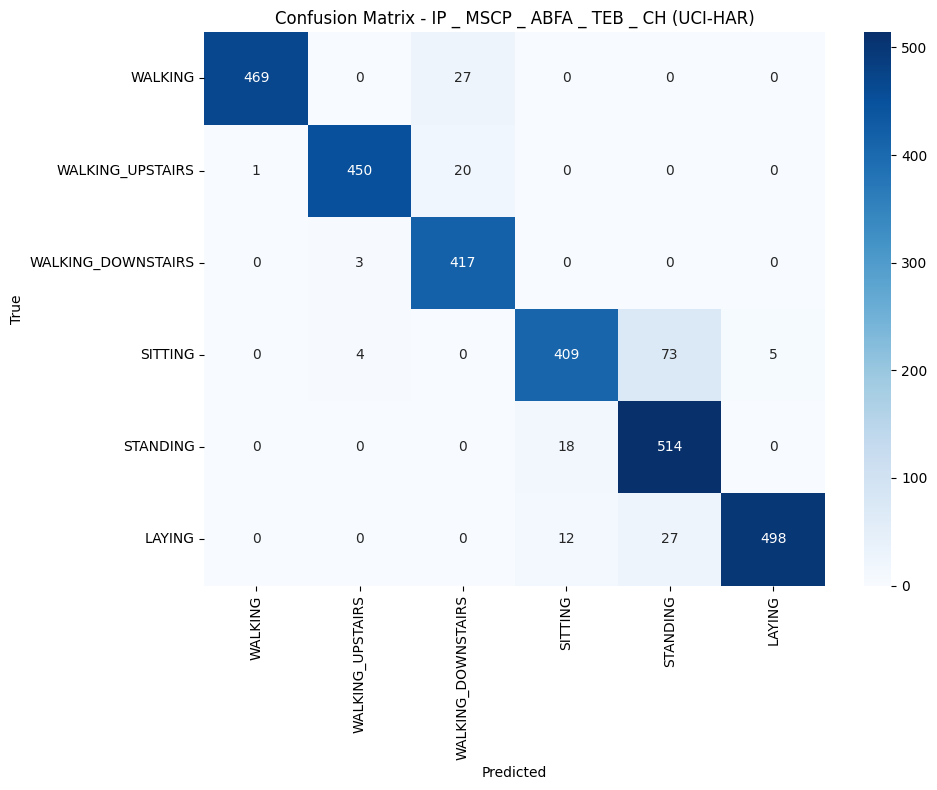


Evaluation Metrics for IP _ MSCP _ ABFA _ TEB _ CH on UCI-HAR:
Accuracy: 0.9355
Precision: 0.9402
Recall: 0.9355
F1 Score: 0.9359

Per-Class Metrics:
WALKING: Accuracy = 0.9905, F1 = 0.9710
WALKING_UPSTAIRS: Accuracy = 0.9905, F1 = 0.9698
WALKING_DOWNSTAIRS: Accuracy = 0.9830, F1 = 0.9434
SITTING: Accuracy = 0.9620, F1 = 0.8796
STANDING: Accuracy = 0.9600, F1 = 0.8970
LAYING: Accuracy = 0.9851, F1 = 0.9577
Model saved as model12356_UCI-HAR.h5

Building and training model: IP _ MSCP _ ABFA _ MST _ CH


Model: "model12346"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 128, 42)   │     16,170 │ re_lu_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 128, 42)   │     37,674 │ re_lu_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 128, 42)   │     59,178 │ re_lu_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_57[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_58[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 128, 128)  │     16,256 │ concatenate_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_6 (ABFA)       │ (None, 128, 128)  │     34,560 │ re_lu_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_3        │ (None, 128, 128)  │     35,328 │ abfa_6[0][0]      │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ mst__block_3[0][

 Total params: 235,068 (918.23 KB)

 Trainable params: 233,920 (913.75 KB)

 Non-trainable params: 1,148 (4.48 KB)


Total params: 235,068
Trainable params: 233,920
Non-trainable params: 1,148
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.5839 - loss: 1.3961 - val_accuracy: 0.8899 - val_loss: 0.3605 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9123 - loss: 0.2973 - val_accuracy: 0.9381 - val_loss: 0.1410 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9317 - loss: 0.1809 - val_accuracy: 0.9558 - val_loss: 0.1056 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9466 - loss: 0.1380 - val_accuracy: 0.9606 - val_loss: 0.0954 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9474 - loss: 0.1246 - val_accuracy: 0.9619 - val_loss: 0.0930 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9459 - loss: 0.1225 - val_accuracy: 0.9592 - val_loss: 0.0883 - 

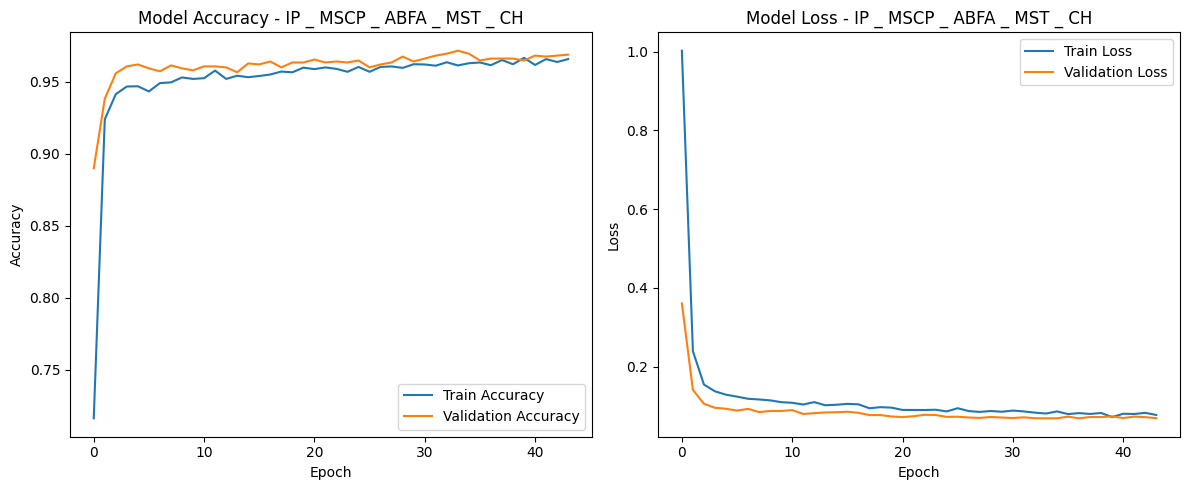

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


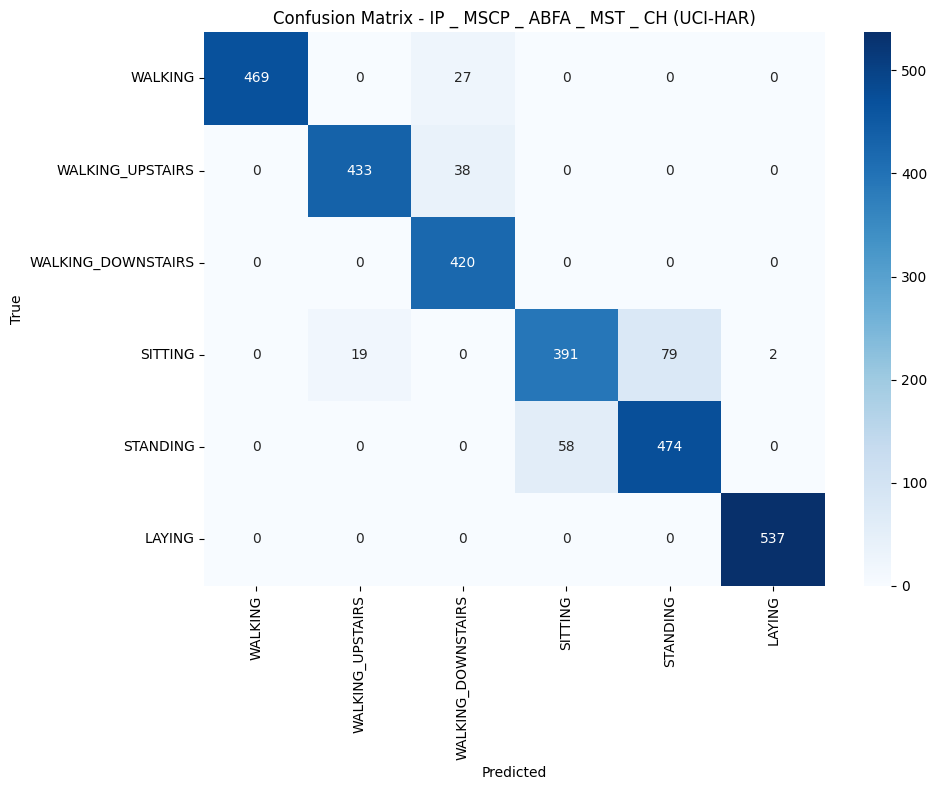


Evaluation Metrics for IP _ MSCP _ ABFA _ MST _ CH on UCI-HAR:
Accuracy: 0.9243
Precision: 0.9262
Recall: 0.9243
F1 Score: 0.9240

Per-Class Metrics:
WALKING: Accuracy = 0.9908, F1 = 0.9720
WALKING_UPSTAIRS: Accuracy = 0.9807, F1 = 0.9382
WALKING_DOWNSTAIRS: Accuracy = 0.9779, F1 = 0.9282
SITTING: Accuracy = 0.9464, F1 = 0.8319
STANDING: Accuracy = 0.9535, F1 = 0.8737
LAYING: Accuracy = 0.9993, F1 = 0.9981
Model saved as model12346_UCI-HAR.h5

Building and training model: IP _ MSCP _ MST _ TEB _ CH


Model: "model12456"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_65[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 128, 42)   │     16,170 │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 128, 42)   │     37,674 │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 128, 42)   │     59,178 │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_67[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 128, 128)  │     16,256 │ concatenate_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_4        │ (None, 128, 128)  │     35,328 │ re_lu_29[0][0]    │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ mst__block_4[0][… │
│ (MultiHeadAttentio… │                   │            │ mst__block_4[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 366,012 (1.40 MB)

 Trainable params: 365,120 (1.39 MB)

 Non-trainable params: 892 (3.48 KB)


Total params: 366,012
Trainable params: 365,120
Non-trainable params: 892
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.6540 - loss: 0.9905 - val_accuracy: 0.9062 - val_loss: 0.3051 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9362 - loss: 0.2040 - val_accuracy: 0.9456 - val_loss: 0.1189 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9448 - loss: 0.1537 - val_accuracy: 0.9388 - val_loss: 0.1484 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9454 - loss: 0.1344 - val_accuracy: 0.9585 - val_loss: 0.0968 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9482 - loss: 0.1238 - val_accuracy: 0.9613 - val_loss: 0.0914 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9438 - loss: 0.1335 - val_accuracy: 0.9592 - val_loss: 0.1058 - le

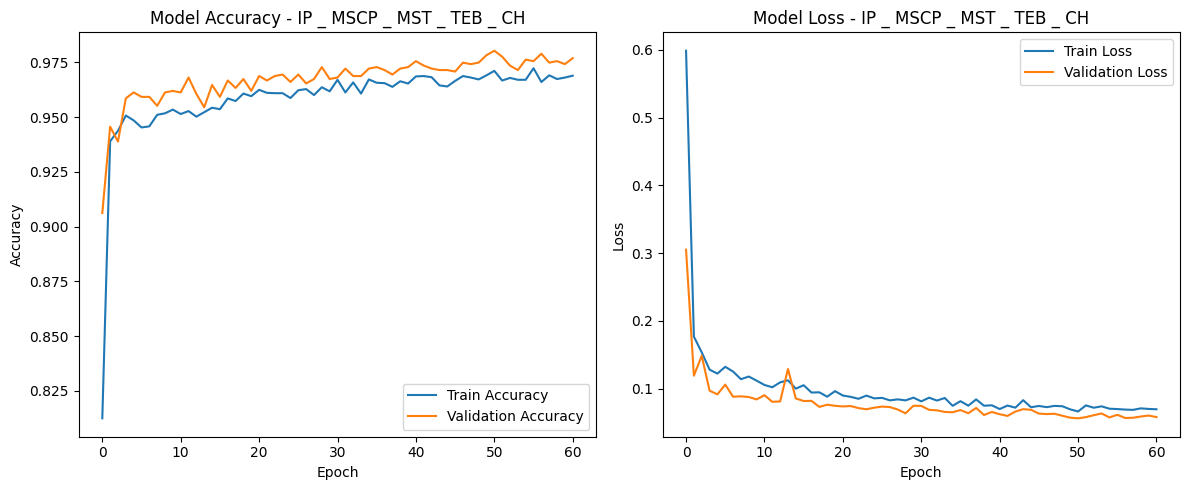

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


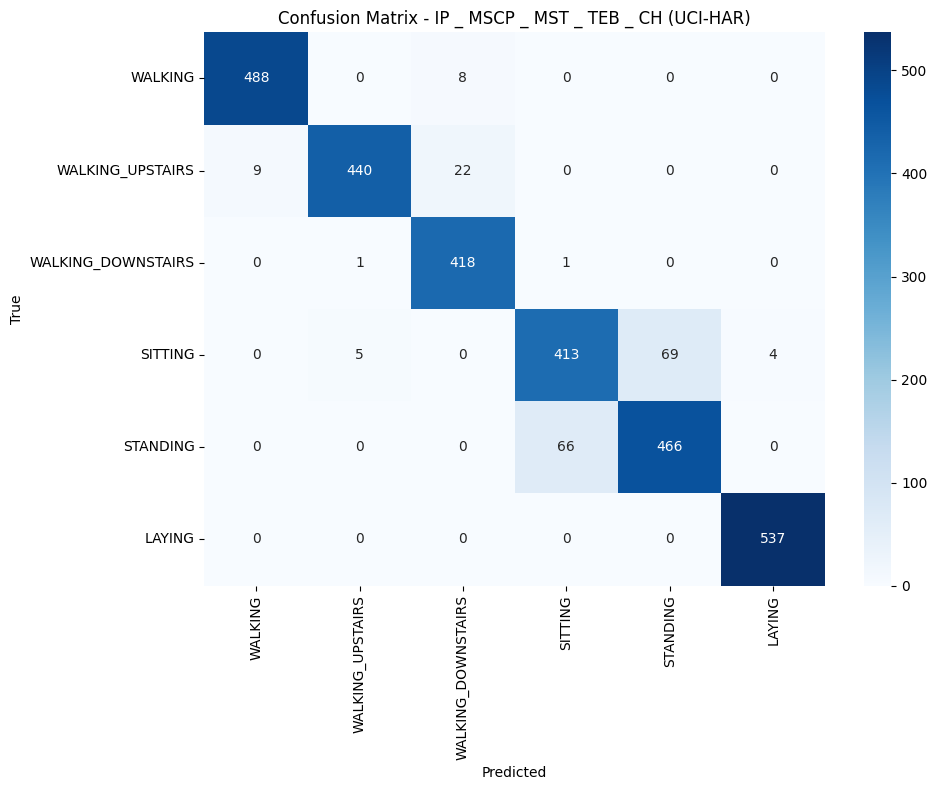


Evaluation Metrics for IP _ MSCP _ MST _ TEB _ CH on UCI-HAR:
Accuracy: 0.9372
Precision: 0.9374
Recall: 0.9372
F1 Score: 0.9370

Per-Class Metrics:
WALKING: Accuracy = 0.9942, F1 = 0.9829
WALKING_UPSTAIRS: Accuracy = 0.9874, F1 = 0.9597
WALKING_DOWNSTAIRS: Accuracy = 0.9891, F1 = 0.9631
SITTING: Accuracy = 0.9508, F1 = 0.8507
STANDING: Accuracy = 0.9542, F1 = 0.8735
LAYING: Accuracy = 0.9986, F1 = 0.9963
Model saved as model12456_UCI-HAR.h5

Building and training model: IP _ MSCP _ ABFA _ MST _ TEB _ CH


Model: "model123456"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 128, 128)  │      8,320 │ re_lu_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_75[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 128, 42)   │     16,170 │ re_lu_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 128, 42)   │     37,674 │ re_lu_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 128, 42)   │     59,178 │ re_lu_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_76[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_77[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_38      │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 128, 128)  │     16,256 │ concatenate_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_79[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_7 (ABFA)       │ (None, 128, 128)  │     34,560 │ re_lu_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_5        │ (None, 128, 128)  │     35,328 │ abfa_7[0][0]      │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ mst__block_5[0][

 Total params: 400,572 (1.53 MB)

 Trainable params: 399,424 (1.52 MB)

 Non-trainable params: 1,148 (4.48 KB)


Total params: 400,572
Trainable params: 399,424
Non-trainable params: 1,148
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.6137 - loss: 1.0224 - val_accuracy: 0.9368 - val_loss: 0.1873 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9351 - loss: 0.2101 - val_accuracy: 0.9538 - val_loss: 0.1100 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9472 - loss: 0.1422 - val_accuracy: 0.9531 - val_loss: 0.0968 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9484 - loss: 0.1300 - val_accuracy: 0.9585 - val_loss: 0.0921 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9494 - loss: 0.1238 - val_accuracy: 0.9579 - val_loss: 0.0892 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9563 - loss: 0.1078 - val_accuracy: 0.9585 - val_loss: 0.0884 -

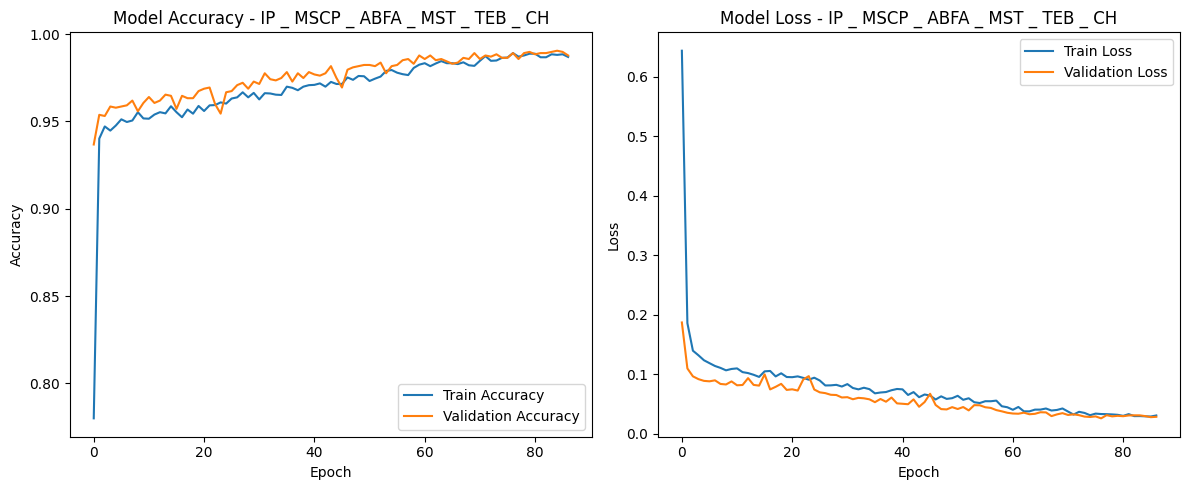

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


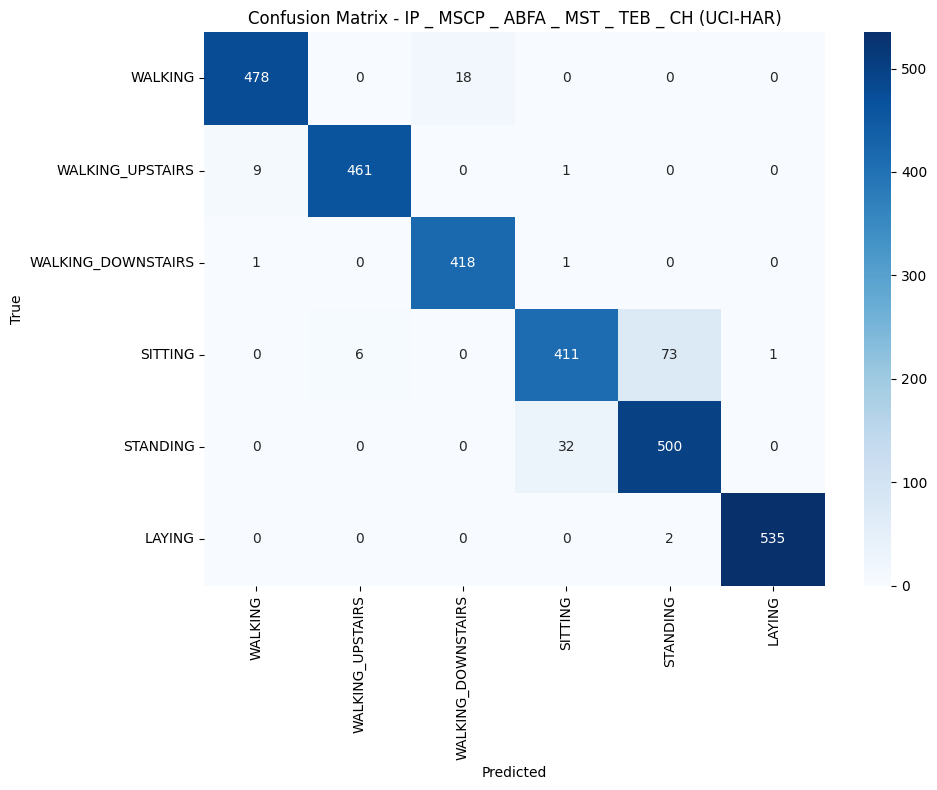


Evaluation Metrics for IP _ MSCP _ ABFA _ MST _ TEB _ CH on UCI-HAR:
Accuracy: 0.9511
Precision: 0.9520
Recall: 0.9511
F1 Score: 0.9509

Per-Class Metrics:
WALKING: Accuracy = 0.9905, F1 = 0.9715
WALKING_UPSTAIRS: Accuracy = 0.9946, F1 = 0.9829
WALKING_DOWNSTAIRS: Accuracy = 0.9932, F1 = 0.9766
SITTING: Accuracy = 0.9613, F1 = 0.8782
STANDING: Accuracy = 0.9637, F1 = 0.9033
LAYING: Accuracy = 0.9990, F1 = 0.9972
Model saved as model123456_UCI-HAR.h5


Final Results for UCI-HAR Dataset:
                            Model  Parameters  Accuracy       F1  Precision   Recall
                   IP _ MSCP _ CH      165180  0.937564 0.937204   0.938754 0.937564
            IP _ MSCP _ ABFA _ CH      199740  0.935188 0.935192   0.936273 0.935188
             IP _ MSCP _ MST _ CH      200508  0.944011 0.943888   0.944482 0.944011
             IP _ MSCP _ TEB _ CH      330684  0.939600 0.939340   0.940432 0.939600
                   IP _ ABFA _ CH       69446  0.906685 0.906828   0.911445 0.90668

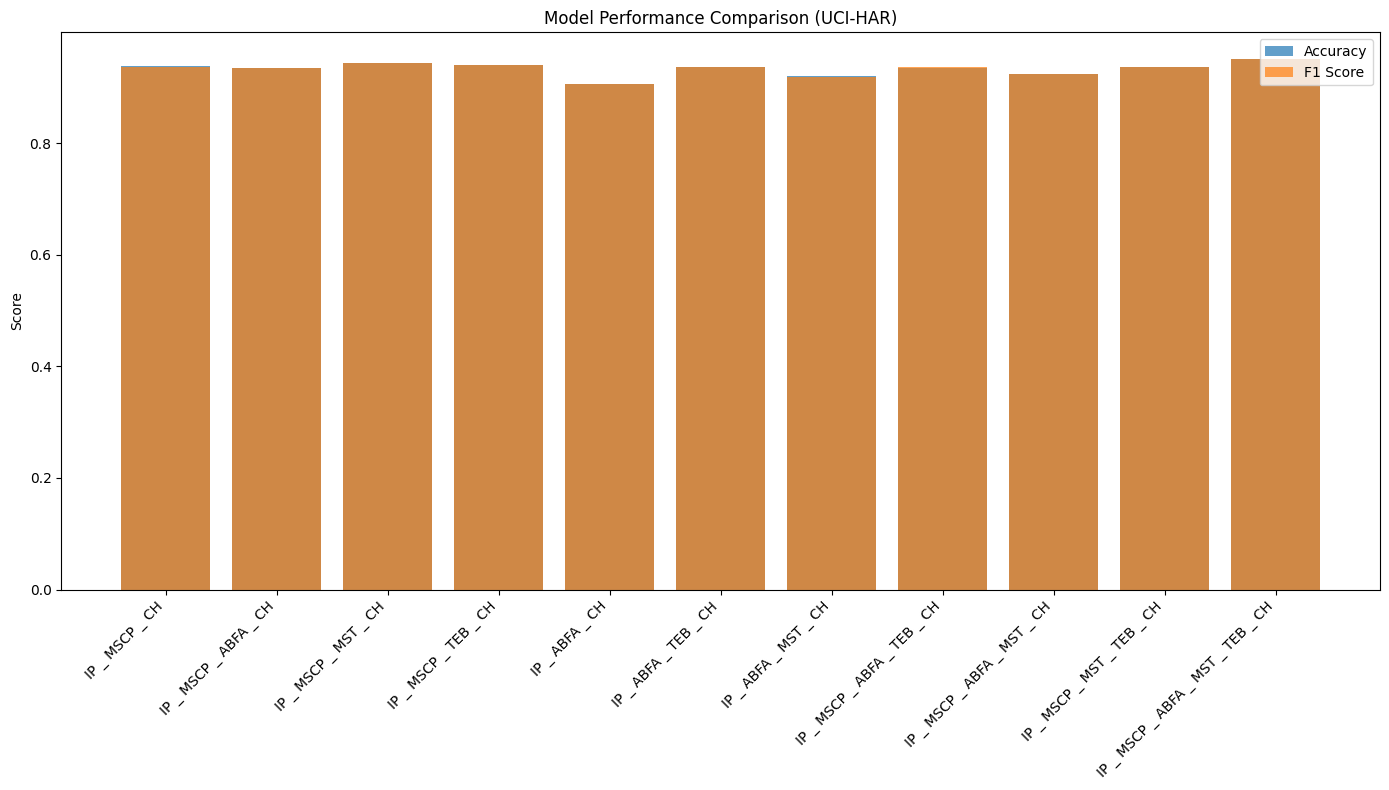

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def build_ablation_model(components, input_shape, num_classes=6):
    # Decode components
    has_ip = 1 in components  # Initial Projection (always included)
    has_mscp = 2 in components  # Multi-Scale CNN Path
    has_abfa = 3 in components  # ABFA Block
    has_mst = 4 in components  # MST_Block
    has_teb = 5 in components  # Transformer Encoder Block
    has_ch = 6 in components  # Classification Head (always included)

    # Get model name - 수정된 부분: 특수문자 제거, 간단한 이름 사용
    component_str = ""
    if 1 in components: component_str += "1"
    if 2 in components: component_str += "2"
    if 3 in components: component_str += "3"
    if 4 in components: component_str += "4"
    if 5 in components: component_str += "5"
    if 6 in components: component_str += "6"

    model_name = f"model{component_str}"

    # 각 컴포넌트의 display 이름 (출력용)
    model_display_name = "Model"
    for comp in components:
        if comp == 1: model_display_name += "_IP"
        elif comp == 2: model_display_name += "_MSCP"
        elif comp == 3: model_display_name += "_ABFA"
        elif comp == 4: model_display_name += "_MST"
        elif comp == 5: model_display_name += "_TEB"
        elif comp == 6: model_display_name += "_CH"

    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = inputs

    # [Initial Projection]
    if has_ip:
        x = layers.Conv1D(64, kernel_size=1, activation=None)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv1D(128, kernel_size=1, activation=None)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # [Multi-Scale CNN Path]
    if has_mscp:
        kernel_sizes = [3, 7, 11]
        multi_scale_outputs = []
        for k in kernel_sizes:
            branch = layers.Conv1D(
                filters=128 // len(kernel_sizes),
                kernel_size=k,
                padding='same',
                activation='relu'
            )(x)
            branch = layers.BatchNormalization()(branch)
            multi_scale_outputs.append(branch)

        x = layers.Concatenate()(multi_scale_outputs)
        x = layers.Conv1D(128, kernel_size=1)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # [ABFA block]
    if has_abfa:
        x = ABFA(filters=128, activity_classes=num_classes)(x)

    # [MST block]
    if has_mst:
        x = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(x)

    # [Transformer Encoder block]
    if has_teb:
        attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)
        ffn_output = layers.Dense(128, activation='relu')(x)
        ffn_output = layers.Dense(128)(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization()(x)

    # [Classification Head]
    if has_ch:
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)
    else:
        outputs = x  # Fallback, should never happen

    model = models.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model, model_display_name

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_display_name, dataset_name="UCI-HAR"):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Per-class metrics
    class_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
    class_accuracy = []
    class_f1 = []

    for cls in range(len(class_names)):
        # Binary classification for each class
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)
        class_accuracy.append(accuracy_score(y_true_cls, y_pred_cls))
        class_f1.append(f1_score(y_true_cls, y_pred_cls, average='binary'))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_display_name} ({dataset_name})')
    plt.tight_layout()
    plt.show()

    # Print results
    print(f"\nEvaluation Metrics for {model_display_name} on {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nPer-Class Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: Accuracy = {class_accuracy[i]:.4f}, F1 = {class_f1[i]:.4f}")

    # Return all metrics as a dict for later comparison
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'class_accuracy': class_accuracy,
        'class_f1': class_f1
    }

    return metrics, y_pred

# Define the configurations to test
ablation_configs = [
    [1, 2, 6],              # IP + MSCP + CH
    [1, 2, 3, 6],           # IP + MSCP + ABFA + CH
    [1, 2, 4, 6],           # IP + MSCP + MST + CH
    [1, 2, 5, 6],           # IP + MSCP + TEB + CH
    [1, 3, 6],              # IP + ABFA + CH
    [1, 3, 5, 6],           # IP + ABFA + TEB + CH
    [1, 3, 4, 6],           # IP + ABFA + MST + CH
    [1, 2, 3, 5, 6],        # IP + MSCP + ABFA + TEB + CH
    [1, 2, 3, 4, 6],        # IP + MSCP + ABFA + MST + CH
    [1, 2, 4, 5, 6],        # IP + MSCP + MST + TEB + CH
    [1, 2, 3, 4, 5, 6],     # Full model
]

# Prepare to store results
results = []

# Run the ablation study
for config in ablation_configs:
    # 모델의 구성 요소 표시 (사람이 읽기 좋은 형태)
    component_desc = []
    if 1 in config: component_desc.append("IP")
    if 2 in config: component_desc.append("MSCP")
    if 3 in config: component_desc.append("ABFA")
    if 4 in config: component_desc.append("MST")
    if 5 in config: component_desc.append("TEB")
    if 6 in config: component_desc.append("CH")
    component_str = " _ ".join(component_desc)

    print(f"\n{'='*50}")
    print(f"Building and training model: {component_str}")
    print(f"{'='*50}")

    # Build model
    model, model_display_name = build_ablation_model(config, input_shape=(window_size, X_train_seq.shape[2]), num_classes=6)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary and parameter count
    model.summary()

    # 수정된 부분: get_shape() 메서드 대신 shape 속성 사용
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params

    print(f"\nTotal params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {non_trainable_params:,}")

    # Train the model
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-5
    )

    history = model.fit(
        X_train_split,
        y_train_split,
        epochs=100,  # Using early stopping
        batch_size=32,
        validation_data=(X_val_split, y_val_split),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy - {component_str}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss - {component_str}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate on test data
    metrics, _ = evaluate_model(model, X_test_seq, y_test_seq_onehot, component_str, "UCI-HAR")

    # Save the results
    results.append({
        'Model': component_str,
        'Parameters': total_params,
        'Accuracy': metrics['accuracy'],
        'F1': metrics['f1'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall']
    })

    # Save the model
    model_save_name = f"model{''.join(str(c) for c in config)}_UCI-HAR"
    model.save(f"{model_save_name}.h5")
    print(f"Model saved as {model_save_name}.h5")

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\n\nFinal Results for UCI-HAR Dataset:")
print(results_df.to_string(index=False))

# Create a visualization of the results
plt.figure(figsize=(14, 8))
plt.bar(np.arange(len(results_df)), results_df['Accuracy'], alpha=0.7, label='Accuracy')
plt.bar(np.arange(len(results_df)), results_df['F1'], alpha=0.7, label='F1 Score')
plt.xticks(np.arange(len(results_df)), results_df['Model'], rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Model Performance Comparison (UCI-HAR)')
plt.legend()
plt.tight_layout()
plt.show()